In [18]:
"""
Iraq War Newspaper Sentiment Analysis
version: M. W-C. Wong, 2019-05-09

Python ver. 3.6.4
numpy ver. 1.16.0
pandas ver. 0.23.4
seaborn ver. 0.9.0
matplotlib ver. 2.1.2
scikit-learn ver. 0.20.3
XGBoost ver. 0.82
lightgbm ver. 2.2.3
keras ver. 2.2.4


Overview:
            Scikit-learn based pipelines for Iraq War newspaper article sentiment analysis. Coded for binary optimism
            vs. pessimism classification.
            
            


Notes:     (1) Python 3.6 Anaconda
           (2) Encoding UTF-8
           (3) Runs from directory with the following files
                            lipad-house-senate-doc2vec-42nd.csv
           (4) Each classifier is trained on two interlocking pipelines, one for the preprocessing column transformer 
               and the other for the classifier/preprocessor training process

"""

'\nIraq War Newspaper Sentiment Analysis\nversion: M. W-C. Wong, 2019-05-09\n\nPython ver. 3.6.4\nnumpy ver. 1.16.0\npandas ver. 0.23.4\nseaborn ver. 0.9.0\nmatplotlib ver. 2.1.2\nscikit-learn ver. 0.20.3\nXGBoost ver. 0.82\nlightgbm ver. 2.2.3\nkeras ver. 2.2.4\n\n\nOverview:\n            Scikit-learn based pipelines for Iraq War newspaper article sentiment analysis. Coded for binary optimism\n            vs. pessimism classification.\n            \n            \n\n\nNotes:     (1) Python 3.6 Anaconda\n           (2) Encoding UTF-8\n           (3) Runs from directory with the following files\n                            lipad-house-senate-doc2vec-42nd.csv\n           (4) Each classifier is trained on two interlocking pipelines, one for the preprocessing column transformer \n               and the other for the classifier/preprocessor training process\n\n'

# Module Calls

In [1]:
############### PYTHON 3



#Module Imports
import platform
import sklearn
import matplotlib
import re
import json
import lightgbm
import keras
import xgboost
import pickle
import mglearn
import re
import gensim

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from joblib import dump, load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split
from dask_searchcv import RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from bs4 import BeautifulSoup

from keras import layers
from keras.models import Sequential
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

%matplotlib inline


print("Python ver. "+platform.python_version())
print("numpy ver. "+np.__version__)
print("pandas ver. "+pd.__version__)
print("seaborn ver. "+sns.__version__)
print("matplotlib ver. "+matplotlib.__version__)
print("scikit-learn ver. "+sklearn.__version__)
print("XGBoost ver. "+xgboost.__version__)
print("lightgbm ver. "+lightgbm.__version__)
print("keras ver. "+keras.__version__)

pd.set_option('display.max_colwidth', -1)

/home/Michael/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Python ver. 3.6.4
numpy ver. 1.16.0
pandas ver. 0.23.4
seaborn ver. 0.9.0
matplotlib ver. 2.1.2
scikit-learn ver. 0.20.3
XGBoost ver. 0.82
lightgbm ver. 2.2.3
keras ver. 2.2.4


# Initial Analyses

In [20]:
## Data Read-in, ignore unnecessary columns
data = pd.read_csv("Data/twitter_sentiment_data/training.1600000.processed.noemoticon.csv",encoding = "ISO-8859-1",usecols=[0,5],names=["Sentiment Score","Tweet"])
data.tail()

,Sentiment Score,Tweet
1599995,4,Just woke up. Having no school is the best feeling ever
1599996,4,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur
1599999,4,happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H


       Sentiment Score
count  1.600000e+06   
mean   2.000000e+00   
std    2.000001e+00   
min    0.000000e+00   
25%    0.000000e+00   
50%    2.000000e+00   
75%    4.000000e+00   
max    4.000000e+00   
1600000


/home/Michael/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


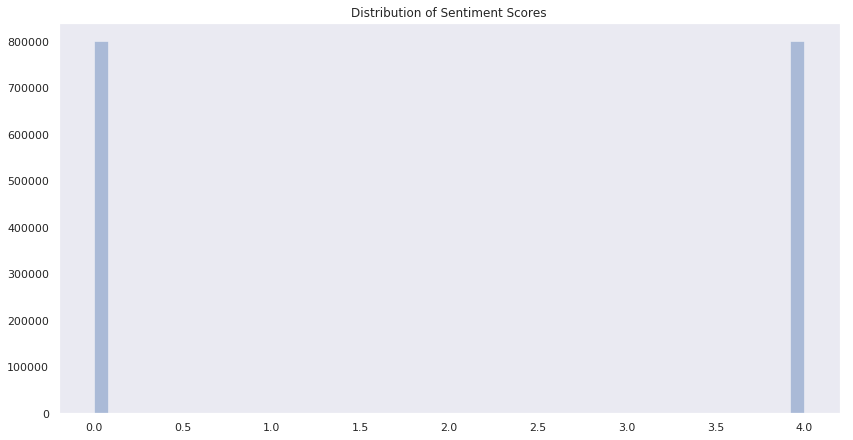

In [21]:
## Initial Data Visualization
print(data.describe())
print(len(data))
#print(data["Sentiment Score"].tolist())


fig, ax = plt.subplots(figsize=[14,7])
sentiment_histogram = sns.distplot(data["Sentiment Score"].tolist(), kde=False)#, height=7, aspect=0.9)
sns.set()
plt.subplots_adjust(top=0.9)
plt.title("Distribution of Sentiment Scores")
plt.grid()
#plt.savefig('figures\sns fig1.png') 

In [22]:
## Manually convert sentiment scores to positive/negative binary categories and move to target array

X = data.copy()
y = ["Positive" if sentiment == 4 else "Negative" for sentiment in X["Sentiment Score"]]

#Since sentiment can be considered to be ordinal, use label encoder
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

X = X.drop("Sentiment Score", axis=1)
display(X)
display(y)
print(le.classes_)
print(len(y))

,Tweet
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,@Kwesidei not the whole crew
6,Need a hug
7,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,@Tatiana_K nope they didn't have it
9,@twittera que me muera ?


array([0, 0, 0, ..., 1, 1, 1])

['Negative' 'Positive']
1600000


In [23]:
## Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.9, random_state=42)
#display(X_train)

display(X_train)
#display(X_valid)
display(y_train)
display(len(y_train))
#display(y_valid)

,Tweet
644091,God I'm sort of annoying its like great+ awful+fabulous at the same time! hahahahah shit
721723,"In VT, missing my hubby"
1057340,just got a present from apple
628980,@martinsays I want the new album â¥kinda of impossible
172036,"@LizzieGrubman have a great time in the Hamptons. Hope it's for some relaxation, not for work"
298089,"@bunnydozer Not lazy, missy. Actually been crazy busy and they're only open during certain hours. Plus they're 30min away from me"
391122,Hangovers are no fun
499323,@jennettemccurdy watching a sad episode of One Tree Hill on the other hand I hear you've been nominated for Best TV Sidekick
70209,@kinagrannis kina! http://tinyurl.com/ct546v why no Uke??
1329322,@shani_texas its almost over girl! I'm feeling giddy


array([0, 0, 1, ..., 0, 0, 0])

160000

In [24]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X, y, test_size=0.9, random_state=43)

## Preprocessing

In [25]:
## Example 
# ANOVA SVM-C
'''anova_filter = SelectKBest(f_regression, k=5)
clf = svm.SVC(kernel='linear')
anova_svm = Pipeline([('anova', anova_filter), ('svc', clf)])
# You can set the parameters using the names issued
# For instance, fit using a k of 10 in the SelectKBest
# and a parameter 'C' of the svm
anova_svm.set_params(anova__k=10, svc__C=.1).fit(X, y)
                      
Pipeline(memory=None,
         steps=[('anova', SelectKBest(...)),
                ('svc', SVC(...))])
prediction = anova_svm.predict(X)
#anova_svm.score(X, y)                        
#0.83'''

"anova_filter = SelectKBest(f_regression, k=5)\nclf = svm.SVC(kernel='linear')\nanova_svm = Pipeline([('anova', anova_filter), ('svc', clf)])\n# You can set the parameters using the names issued\n# For instance, fit using a k of 10 in the SelectKBest\n# and a parameter 'C' of the svm\nanova_svm.set_params(anova__k=10, svc__C=.1).fit(X, y)\n                      \nPipeline(memory=None,\n         steps=[('anova', SelectKBest(...)),\n                ('svc', SVC(...))])\nprediction = anova_svm.predict(X)\n#anova_svm.score(X, y)                        \n#0.83"

In [26]:
## Create preprocessing pipelines

## Column selector (removes non-essential columns as defined by user), X must be a pandas dataframe
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

## Custom transforms and preprocessing pipeline steps

In [27]:
## Numeric features if applicable
#numeric_features = ['age', 'fare']
#numeric_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler())])

## Categorical features if applicable
#categorical_features = ["Sentiment Score"]
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', numeric_transformer, numeric_features),
#        ("cat", categorical_transformer, categorical_features)])

## Create custom transformer
class Tweet_cleaner(BaseEstimator, TransformerMixin):
    """
    Cleans tweets by removing urls
    
    """
    def __init__(self, verbose=False):
        self.verbose = verbose
        
    def fit(self, X, y=None):
        if self.verbose:
            print("Verbose mode on!")
        return self
    
    def transform(self, X, y=None):
        #display(X)
        #Use beautifulsoup to decode HTML code
        if self.verbose:
            print("Preprocessing...")
            
        X_1 = [(BeautifulSoup(tweet,"lxml").get_text()) for tweet in X["Tweet"]]
        #X_2 = [re.sub(r"@[A-Za-z0-9]+","",tweet) for tweet in X_1]
        X_3 = [re.sub("https?://[A-Za-z0-9./]+","",tweet) for tweet in X_1]
        X_4 = [re.sub("www.[A-Za-z0-9./]+","",tweet) for tweet in X_3]
        #X_5 = [(tweet.decode("utf-8-sig")).replace(u"\ufffd","") for tweet in X_4]
        #X_5 = [re.sub("[^a-zA-Z]"," ", tweet) for tweet in X_4]
        
        if self.verbose:
        #display(X_4)
            print("Preprocess Complete")

        return X_4
    

class Keras_tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False, path=None, load_tokenizer=True, nb_words):
        self.verbose = verbose
        self.path = path
        self.nb_words = nb_words
        self.load_tokenizer = load_tokenizer
        
    def fit(self, X, y=None):
        if self.verbose:
            print("Verbose mode on!")
        return self
    
    def transform(self, X, y=None):
        #display(X)
        ## Use Keras tokenizer and padding for neural net inputs
        if self.verbose:
            print("Tokenizing...")
            
        if self.load_tokenizer:
            with open(os.path.join(self.path, "keras_tokenizer.pkl"), "rb") as handle:
                tokenizer = pickle.load(handle)
        else:
            tokenizer = Tokenizer(nb_words=self.nb_words,lower=True,split=' ')
            tokenizer.fit_on_texts(X["Tweet"].tolist())
            #print(tokenizer.word_index)  # To see the dictionary
            with open(os.path.join(self.path, "keras_tokenizer.pkl"), "wb") as handle:
                pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
        encoded_sentences = tokenizer.texts_to_sequences(X["Tweet"].tolist())
        padded_sentences = pad_sequences(X["Tweet"].tolist(), maxlen=50, padding="post")
        
        if self.verbose:
            display(padded_sentences[:50])
            print("Tokenization Complete")

        return padded_sentences
    
    
class Gensim_doc2vec(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose

    def fit(self, X, y=None):
        if(self.verbose):
            print("Verbose mode on!")
        return self
    
    def transform(self, X, y=None):
        ## Train gensim doc2vec embeddings
        tokenizer = Tokenizer(nb_words=2500,lower=True,split=' ')
        tokenizer.fit_on_texts(X["Tweet"].tolist())
        #print(tokenizer.word_index)  # To see the dictionary
        with open("keras_tokenizer.pkl", "wb") as handle:
            pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
        encoded_sentences = tokenizer.texts_to_sequences(X["Tweet"].tolist())
        padded_sentences = pad_sequences(X["Tweet"].tolist(),maxlen=50,padding="post")
        display(padded_sentences)
        
        print("Tokenization Complete")

        return padded_sentences
    
    
## Categorical features if applicable
tweet_col = ["Tweet"]
tweet_transformer_pipe = Pipeline(steps=[
    ("cleaner", tweet_cleaner()),
    ("tfidf_vectorizer", TfidfVectorizer())
    ])

#tweet_transformer_keras = Pipeline(steps=[
#    ("cleaner", tweet_cleaner()),
#    ("keras_tokenizer", keras_tokenizer())
#    ])
                      
preprocessor = ColumnTransformer(
    transformers=[
        ("tweet_transformer", tweet_transformer_pipe, tweet_col)
        ])

preprocessor_keras = ColumnTransformer(
    transformers=[
        ("tweet_transformer_keras", tweet_transformer_keras, tweet_col)
        ])

## Pipeline Initialization

In [28]:
## Initialize classifiers

## Long short-term memory neural network
def Create_LSTM(embed_dim=128,lstm_out=200):#,dropout=0.2,dropout_U=0.2,dropout_W=0.2):
    #embed_dim = 128
    #lstm_out = 200
    #dropout = 0.2
    #dropout_U = 0.2
    #dropout_W = 0.2

    model = Sequential()
    model.add(layers.Embedding(input_dim=40,output_dim=embed_dim))#,dropout=dropout))
    model.add(layers.LSTM(lstm_out))#,dropout_U=dropout_U,dropout_W=dropout_W))
    model.add(layers.Dense(2,activation="softmax"))
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
    print(model.summary())

    return model


## Multinomial Naive Bayes
nb_clf = MultinomialNB()
nb_clf_fullpipe = Pipeline(steps=[
                            ("preprocessor", preprocessor),
                            ("nb_classifier", nb_clf)
                            ])
print(nb_clf_fullpipe)
print("")

## Logistic Regression
lr_clf = LogisticRegression(verbose=2)
lr_clf_fullpipe = Pipeline(steps=[
                            ("preprocessor", preprocessor),
                            ("lr_classifier", lr_clf)
                            ])
print(lr_clf_fullpipe)
print("")

## Random Forest
rf_clf = RandomForestClassifier(verbose=2)
rf_clf_fullpipe = Pipeline(steps=[
                            ("preprocessor", preprocessor),
                            ("rf_classifier", rf_clf)
                            ])
print(rf_clf_fullpipe)
print("")


## Gradient Boost
gb_clf = GradientBoostingClassifier(verbose=2)
gb_clf_fullpipe = Pipeline(steps=[
                            ("preprocessor", preprocessor),
                            ("gb_classifier", gb_clf)
                            ])
print(gb_clf_fullpipe)
print("")


## LightGBM
lgbm_clf = LGBMClassifier(silent=False,n_jobs=1)
lgbm_clf_fullpipe = Pipeline(steps=[
                                ("preprocessor", preprocessor),
                                ("lgbm_classifier", lgbm_clf)
                            ])
print(lgbm_clf_fullpipe)
print("")


## XGBoost
xgb_clf = XGBClassifier(verbosity=1)
xgb_clf_fullpipe = Pipeline(steps=[
                                ("preprocessor", preprocessor),
                                ("xgb_classifier", xgb_clf)
                            ])
print(xgb_clf_fullpipe)
print("")


## Support Vector Classification
svm_clf = SVC(verbose=2)
svm_clf_fullpipe = Pipeline(steps=[
                                ("preprocessor", preprocessor),
                                ("svm_classifier", svm_clf)
                            ])
print(svm_clf_fullpipe)

# wrap the model using the function you created
LSTM_clf = KerasClassifier(build_fn=create_LSTM,verbose=2)

LSTM_clf_fullpipe = Pipeline(steps=[
                                ("preprocessor", preprocessor),
                                ("lstm_classifier", LSTM_clf)
                            ])
print(LSTM_clf_fullpipe)

'''
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
# define documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# load the whole embedding into memory
embeddings_index = dict()
f = open('../glove_data/glove.6B/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

'''

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('tweet_transformer', Pipeline(memory=None,
     steps=[('cleaner', tweet_cleaner(verbose=False)), ('tfidf_vectorizer', TfidfVectorizer(analyzer='w...e))]), ['Tweet'])])), ('nb_classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('tweet_transformer', Pipeline(memory=None,
     steps=[('cleaner', tweet_cleaner(verbose=False)), ('tfidf_vectorizer', TfidfVectorizer(analyzer='w...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=2, warm_start=False))])

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         tra

"\nfrom numpy import array\nfrom numpy import asarray\nfrom numpy import zeros\nfrom keras.preprocessing.text import Tokenizer\nfrom keras.preprocessing.sequence import pad_sequences\nfrom keras.models import Sequential\nfrom keras.layers import Dense\nfrom keras.layers import Flatten\nfrom keras.layers import Embedding\n# define documents\ndocs = ['Well done!',\n\t\t'Good work',\n\t\t'Great effort',\n\t\t'nice work',\n\t\t'Excellent!',\n\t\t'Weak',\n\t\t'Poor effort!',\n\t\t'not good',\n\t\t'poor work',\n\t\t'Could have done better.']\n# define class labels\nlabels = array([1,1,1,1,1,0,0,0,0,0])\n# prepare tokenizer\nt = Tokenizer()\nt.fit_on_texts(docs)\nvocab_size = len(t.word_index) + 1\n# integer encode the documents\nencoded_docs = t.texts_to_sequences(docs)\nprint(encoded_docs)\n# pad documents to a max length of 4 words\nmax_length = 4\npadded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')\nprint(padded_docs)\n# load the whole embedding into memory\nembed

In [39]:
## Initiate a full preprocessing and prediction pipeline

max_depth = [int(x) for x in np.linspace(10,110,11)]
max_depth.append(None)

gamma = [x for x in np.logspace(-15,3,base=2,num=7)]
gamma.append("scale")
gamma.append("auto")

## RandomizedSearchCV hyperparameter optimization
nb_param_grid = {
    "nb_classifier__alpha": [1,1e-1,1e-2,0]
    }

lr_param_grid = {
    "lr_classifier__penalty": ["l1","l2"],
    "lr_classifier__C": [1e-3,1e-2,1e-1,1,10]
    }

rf_param_grid = {
    "rf_classifier__n_estimators": [int(x) for x in np.linspace(50,500,11)],
    "rf_classifier__max_depth": max_depth,
    "rf_classifier__max_features": ["auto"],
    "rf_classifier__min_samples_split": [2, 10, 100],
    "rf_classifier__min_samples_leaf": [1, 2, 4, 10],
    }

gb_param_grid = {
    "gb_classifier__n_estimators": [int(x) for x in np.linspace(50,500,11)],
    "gb_classifier__max_depth": max_depth
    }

lgbm_param_grid = {
    "lgbm_classifier__n_estimators": [int(x) for x in np.linspace(50,550,11)],
    "lgbm_classifier__max_depth": max_depth,
    }

xgb_param_grid = {
    "xgb_classifier__n_estimators": [int(x) for x in np.linspace(50,550,11)],
    "xgb_classifier__max_depth": max_depth,  
    }

svm_param_grid = {
    "svm_classifier__C": [x for x in np.logspace(-5,15,base=2,num=7)],
    "svm_classifier__gamma": gamma
    }

lstm_param_grid = {
    "lstm_classifier__embed_dim": [128],
    "lstm_classifier__lstm_out": [200],
    "lstm_classifier__dropout": [0.2],
    "lstm_classifier__dropout_U": [0.2],
    "lstm_classifier__dropout_W": [0.2],
    "lstm_classifier__epochs": [50, 100, 150],
    "lstm_classifier__batch_size": [5, 10, 20]
    }

In [40]:
param_grid = {
    #"preprocessor__tweet_transformer__tfidf_vectorizer__max_df": np.linspace(0.2, 1, 10),
    "preprocessor__tweet_transformer__tfidf_vectorizer__binary": [True],
    "preprocessor__tweet_transformer__tfidf_vectorizer__token_pattern": [r"(?u)\b\w\w+\b|\'"],
    "preprocessor__tweet_transformer__tfidf_vectorizer__ngram_range": [(1,2)],
    }

nb_param_grid.update(param_grid)
lr_param_grid.update(param_grid)
rf_param_grid.update(param_grid)
gb_param_grid.update(param_grid)
lgbm_param_grid.update(param_grid)
xgb_param_grid.update(param_grid)
svm_param_grid.update(param_grid)
lstm_param_grid.update(param_grid)

In [41]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {
            "MultinomialNB" : (nb_clf_fullpipe, nb_param_grid),
            "LogisticRegression" : (lr_clf_fullpipe, lr_param_grid),
            "RandomForest" : (rf_clf_fullpipe, rf_param_grid),
            "GradientBoosting" : (gb_clf_fullpipe, gb_param_grid),
            "XGBoost" : (xgb_clf_fullpipe, xgb_param_grid),
            "LightGBM" : (lgbm_clf_fullpipe, lgbm_param_grid),
            "SVC" : (svm_clf_fullpipe, svm_param_grid),
            "LSTM" : (LSTM_clf_fullpipe, lstm_param_grid)
            }

In [42]:
## Function to fit a model pipeline
def Pipeline_fit(pipeline, search_method, cv, iid, verbose_searchcv, n_jobs, optimization):

    if optimization == True:
        ## Do hyperparameter optimization using RandomizedSearchCV
        
        if search_method == "randomsearch":
            search_cv = RandomizedSearchCV(pipe_dict[pipeline][0], pipe_dict[pipeline][1], 
                                           cv=cv, iid=iid, n_jobs=n_jobs)#verbose=verbose_searchcv, n_jobs=n_jobs)
        elif search_method == "gridsearch":
            search_cv = GridSearchCV(pipe_dict[pipeline][0], pipe_dict[pipeline][1], 
                                     cv=cv, iid=iid, n_jobs=n_jobs)#verbose=verbose_searchcv, n_jobs=n_jobs)
            
        ## Train the model
        print("Training "+pipeline+" on "+str(len(y_train))+" samples...")
        search_cv.fit(X_train, y_train)

        print("")
        print(pipeline+":")
        print("Best Score: ", search_cv.best_score_)
        print("Best Params: ", search_cv.best_params_)

        ## Use joblib to dump the best estimator to joblib file for persistence purposes
        clf_final = search_cv.best_estimator_
        dump(clf_final, "twitter_"+pipeline+".joblib")

        return clf_final
    
    else:
        ## No optimization is performed, fit to model only
        print("Training "+pipeline+" on "+str(len(y_train))+" samples...")
        print(pipe_dict[pipeline][0].steps[1])
        clf_final = pipe_dict[pipeline][0].fit(X_train, y_train)

        ## Use joblib to dump the best estimator to joblib file for persistence purposes
        dump(clf_final, "twitter_"+pipeline+".joblib")

        return clf_final
        

In [ ]:
## Activate full pipeline
"""
lgbm_clf_final = pipeline_fit(pipeline="LightGBM", 
                                search_method="randomsearch",
                                cv=5, 
                                iid=False, 
                                verbose_searchcv=1, 
                                n_jobs=1, 
                                optimization=True)
"""

In [ ]:
"""
nb_clf_final = pipeline_fit(pipeline="MultinomialNB", 
                            search_method="gridsearch",
                            cv=5, 
                            iid=False,
                            verbose_searchcv=1, 
                            n_jobs=1, 
                            optimization=True)
"""

In [ ]:
lr_clf_final = pipeline_fit(pipeline="LogisticRegression", 
                            search_method="gridsearch",
                            cv=5, 
                            iid=False, 
                            verbose_searchcv=2, 
                            n_jobs=1, 
                            optimization=True)

Training LogisticRegression on 160000 samples...
Preprocessing...
Preprocess Complete


/home/Michael/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
Preprocessing...
Preprocess Complete
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Pre

In [ ]:
"""
xgb_clf_final = pipeline_fit(pipeline="XGBoost", 
                            search_method="randomsearch",
                            cv=5, 
                            iid=False, 
                            verbose_searchcv=1, 
                            n_jobs=1, 
                            optimization=True)
"""

In [ ]:
"""
rf_clf_final = pipeline_fit(pipeline="RandomForest", 
                            search_method="randomsearch",
                            cv=5, 
                            iid=False, 
                            verbose_searchcv=1, 
                            n_jobs=1, 
                            optimization=True)
"""

In [ ]:
"""
svm_clf_final = pipeline_fit(pipeline="SVC", 
                            search_method="randomsearch",
                            cv=5, 
                            iid=False, 
                            verbose_searchcv=2, 
                            n_jobs=1, 
                            optimization=True)
"""

In [ ]:
"""
lstm_clf_final = pipeline_fit(pipeline="LSTM", 
                            search_method="randomsearch",
                            cv=5, 
                            iid=False, 
                            verbose_searchcv=2, 
                            n_jobs=1, 
                            optimization=True)
"""

## Predictions

In [15]:
## Load estimator via joblib

#lgbm_clf_final = load("twitter_LightGBM.joblib")
rf_clf_final = load("twitter_RandomForest.joblib")

In [ ]:
#print(lgbm_clf_final.named_steps["lgbm_classifier"])
print(lgbm_clf_final.named_steps)
print("")
#print(rf_clf_final.named_steps["rf_classifier"])

In [ ]:
## Use a soft voting classifier to make final predictions from all models
vote_clf = VotingClassifier(estimators=[
                            ("nb_clf", nb_clf_final.named_steps["nb_classifier"]), 
                            ("rf_clf", rf_clf_final.named_steps["rf_classifier"]),
                            #("gb_clf", gb_clf_final), 
                            #("xgb_clf", xgb_clf_final),
                            ("lgbm_clf", lgbm_clf_final.named_steps["lgbm_classifier"])
                            ], voting="soft")

vote_clf_fullpipe = Pipeline(steps=[
                                ("preprocessor", preprocessor),
                                ("voting_classifier", vote_clf)
                            ])

print(vote_clf_fullpipe)


pipe_dict["VotingClassifier"] = (vote_clf_fullpipe,)

In [ ]:
vote_clf_final = pipeline_fit(pipeline="VotingClassifier", cv=None, iid=False, verbose=2, n_jobs=1, optimization=False)

In [ ]:
#display(X_valid)
y_pred = vote_clf_final.predict(X_valid)
#y_pred = lgbm_clf_final.predict(X_valid)
print("Predicted Targets:",y_pred)
print("Actual Targets:",y_valid)

In [ ]:
y_pred_2 = lgbm_clf_final.predict(X_valid_2)
print("Predicted Targets:",y_pred_2)
print("Actual Targets:",y_valid_2)

In [ ]:
#y_pred_inv = le.inverse_transform(y_pred)
target_names = le.classes_
print("Target names: ",target_names)
n_classes = le.classes_.shape[0]
print("n_classes: ",n_classes)
print("\nClassification Report:")
print(classification_report(y_valid, y_pred, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred, labels=range(n_classes)))

In [ ]:
target_names = le.classes_
print("Target names: ",target_names)
n_classes = le.classes_.shape[0]
print("n_classes: ",n_classes)
print("\nClassification Report:")
print(classification_report(y_valid_2, y_pred_2, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(y_valid_2, y_pred_2, labels=range(n_classes)))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        title = "Confusion matrix"
        
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    ## Get normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print("Confusion Matrix")
    print(cm)
    print("Normalized Confusion Matrix")
    print(cm_norm)

    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(None)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel="True Labels",
           xlabel="Predicted Labels"
          )

    ## Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor")

    ## Loop over data dimensions and create text annotations 
    ## using both normalized and non-normalized confusion matrices
    def annotated_text(i,j):
        return str(cm[i,j])+"\n("+str(format(cm_norm[i,j], ".2f"))+")"
    
    ## Text color switches to provide contrast
    col_switch_thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, annotated_text(i,j),
                    ha="center", va="center",
                    color="white" if cm[i, j] > col_switch_thresh else "black")
    fig.tight_layout()
    return ax


#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_valid, y_pred, classes=le.classes_,title=None)

In [ ]:
#del lgbm_clf_final

## Use mglearn to extract feature/n-gram names and their respective importance coefficients
#print(lgbm_clf_final.named_steps["preprocessor"].transformers_[0][1].named_steps["tfidf_vectorizer"])
vectors = rf_clf_final.named_steps["preprocessor"].transformers_[0][1].named_steps["tfidf_vectorizer"]
feature_names = np.array(vectors.get_feature_names())
coeff = rf_clf_final.named_steps["rf_classifier"].feature_importances_
mglearn.tools.visualize_coefficients(coeff,feature_names,n_top_features=40)